# Create VIL example

In this notebook we create VIL outputs for use by the MCIT routine in creating StormCell Identifications. We use data from the USA NWS NEXRAD network, which can be downloaded using the getRadarData.py script found in the hotspots.script directory.

In [1]:
from pathlib import Path
import numpy as np
import pyart

from config import _EXAMPLEDATA_DIR



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KTLX20230227_012550_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KOAX20140603_213649_V06.gz')
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KEWX20210504_020040_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KSHV20230613_230228_V06')

In [3]:
#read in the data with pyart
radar_vol = pyart.io.read_nexrad_archive(filename)
#radar_vol.info()

Using the prepro.nexrad module to reduce the number of elevations to the survalence data only (reflectivity) and to have only one elevation for the volume. 

In [4]:
from prepro.nexrad import compute_nexrad_wave_form
from prepro.nexrad import prune_nexrad

prune_actions = ['surv', 'volume']

prune_vol = prune_nexrad(prune_actions, radar_vol)


In [5]:
from cappi.make_vv import get_indexed_vv
ds_azran = get_indexed_vv(prune_vol, ['reflectivity'])

#ds_azran

2024-11-22 14:21:59,569 [MainThread  ] [INFO ]  1 of 14 current_elev: 0.48
2024-11-22 14:21:59,620 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:59,620 [MainThread  ] [INFO ]  2 of 14 current_elev: 0.88
2024-11-22 14:21:59,673 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:59,673 [MainThread  ] [INFO ]  3 of 14 current_elev: 1.32
2024-11-22 14:21:59,723 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:59,724 [MainThread  ] [INFO ]  4 of 14 current_elev: 1.80
2024-11-22 14:21:59,755 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:59,755 [MainThread  ] [INFO ]  5 of 14 current_elev: 2.42
2024-11-22 14:21:59,785 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:21:59,786 [MainThread  ] [INFO ]  6 of 14 current_elev: 3.12
2024-11-22 14:21:59,814 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, nu

In [6]:
#compute the VIL output in azimuth and range coordinates
from mcit.vil import get_vil_from_azran

vil_azran = get_vil_from_azran(ds_azran['reflectivity'])
vil_azran.attrs.update(ds_azran.attrs)

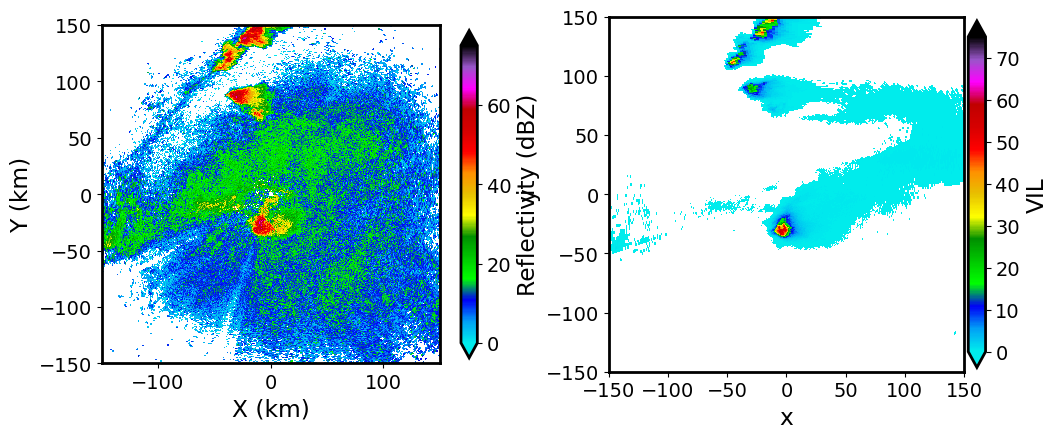

In [7]:
#viewable plots
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_zdr_cmap

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-150, 150]
ylim = [-150, 150]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025
aps = [xlim[0] + axps, ylim[0] + ayps]

sweep = 0

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')

display = pyart.graph.RadarDisplay(radar_vol)
display.set_limits(xlim, ylim, ax=ax1)

display.plot_ppi('reflectivity', ax=ax1, sweep=0,
                 cmap='pyart_NWSRef', vmin=0.0, vmax=75, title_flag=False,
                 colorbar_flag=False, mask_outside=True, axislabels=axislabels)
display.plot_colorbar(extend='both', shrink=0.85, label='Reflectivity (dBZ)')

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_ylabel('')
display.set_limits(xlim, ylim, ax=ax2)


vil_azran.where(vil_azran>-10).plot(ax=ax2, x='x', y='y',
                                           vmin=0.0, vmax=75.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap='pyart_NWSRef',
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9}
                                           )

ax2.set_title("")
plt.show()

out_filename = Path("./test.png")
fig.savefig(out_filename)
plt.close(fig)

In [8]:
#convert the vil from Az/Ran coordinates to xy coordinates

from cappi.xy_cappi import azran_to_xy
x_trg = np.arange(-200, 201)
y_trg = np.arange(-200, 201)

vil_xy = azran_to_xy(vil_azran, x_trg, y_trg, grid_spacing_meters=1000.0)



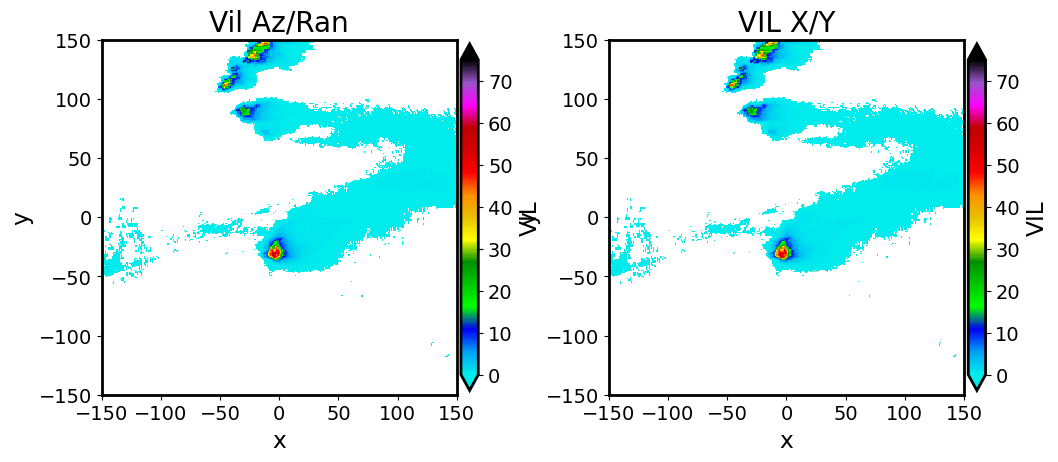

In [9]:
#plot the comparison

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')

vil_xy.where(vil_xy>-10).plot(ax=ax1, x='x', y='y',
                                           vmin=0.0, vmax=75.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap='pyart_NWSRef',
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9}
                                           )

ax1.set_title("Vil Az/Ran")

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_ylabel('')
display.set_limits(xlim, ylim, ax=ax2)


vil_xy.where(vil_xy>-10).plot(ax=ax2, x='x', y='y',
                                           vmin=0.0, vmax=75.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap='pyart_NWSRef',
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9}
                                           )


ax2.set_title("VIL X/Y")
plt.show()

out_filename = Path("./test.png")
fig.savefig(out_filename)
plt.close(fig)